In [18]:
import sys
sys.path.insert(0, '/Users/shiahlints/galvanize/FIXGITPROBLEM/booking-agent-ai')
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import find_nearest_venues as fnv
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
train_events = pd.read_pickle('../data/train_events_df.p')
test_events = pd.read_pickle('../data/test_events_raw_df.p')
train_venues = pd.read_pickle('../data/train_venues_df.p')
artists = pd.read_pickle('../data/master_artists_df.p')


# We start by sampling form the test events
we will use the venue id to get the nearest 100 venues to where this 
event took place. We will then check if the model return this venues 
as one of the top ten recomendations. The model is trained on the train events.
The data has been split in such a way that there is no leakage.

In [3]:
number_of_samples = 50
samples = test_events.sample(number_of_samples)

# Calibrate the vunue finder
The venue finder is calibrated with all the venues
in the training set. This was it will return venues only in the training set.

In [4]:
vf = fnv.Venue_Finder(venues = train_venues)
vf.venues.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6843 entries, 0 to 6842
Data columns (total 10 columns):
venueidentifer    6843 non-null object
venue_name        6843 non-null object
country           6843 non-null object
region            6843 non-null object
city              6843 non-null object
venue_genre       6347 non-null object
venue_bio         6345 non-null object
latitude          6843 non-null float64
longitude         6843 non-null float64
venue_id          6843 non-null int64
dtypes: float64(2), int64(1), object(7)
memory usage: 588.1+ KB


# Make a dataset to train the model on 
and filter out venues without bios

In [5]:
data = train_events[['artist_id', 'venue_bio', 'venue_id']]
data = data[~data.venue_bio.isnull()]

# Train a count vectorizer and a MultinomialNb

In [6]:
vectorizer = CountVectorizer(stop_words = 'english', max_features = 1000)
counts = vectorizer.fit_transform(data['venue_bio'].values)
classifier = MultinomialNB()
targets = data['venue_id'].values
classifier.fit(counts, targets)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

pipeline = Pipeline([
    ('vectorizer',  CountVectorizer(stop_words = 'english', max_features = 1000)),
    ('classifier',  MultinomialNB()) ])

pipeline.fit(data['venue_bio'].values, data['venue_id'].values)

ratings1 = pipeline.predict_proba(['this is a test'])

# Test Model

In [7]:
number_of_samples = 50
samples = test_events.sample(number_of_samples)


In [8]:

new_venue = 0 
model_sucesses = 0
model_failures = 0
number_venues_to_search = 100
top_n_venues = 10
no_bio = 0
for i, event in samples.iterrows():
    artist_id = event.artist_id
    venue_id = event.venue_id
    artist_bio = event.artist_bio
    if venue_id not in train_venues.venue_id.values:
        new_venue += 1
        continue
    
    if artist_bio == None:
        no_bio += 1
        continue
    else:
        # First get a array of the classes. Predict probab only returns the probibility of 
        # document "bio" belonging to a class "venue". We are only interested in local 
        #venues so we need this array to filter the probibilities:
        all_venues = classifier.classes_
        
        # get_nearest_venues_by_venue returns a data_frame contianing all the venue info
        # we are only interested in the venue_id values
        nearest_venues = (vf.get_nearest_venues_by_venue(venue_id, number_venues_to_search).
                          venue_id.values)
        
        # these next to lines return a array of probabilities that relate to the 
        # classes in all_venues
        bio_vectorized = vectorizer.transform([artist_bio])
        ratings = classifier.predict_proba(bio_vectorized).reshape(-1,)
        
        #now we make a filter to get only the venues close by 
        venue_filter = np.isin(all_venues, nearest_venues)
        
        #and apply it on the venues and porbs
        local_venues = all_venues[venue_filter]
        local_probs = ratings[venue_filter]
        
        #Now make a sorter with the provs to sort the venues from most to least likely
        sorter = local_probs.argsort()
        top_local_venues_sorted = local_venues[sorter[:number_venues_to_search-10:-1]]
    
    
        if venue_id in top_local_venues_sorted:
            model_sucesses += 1
        else:
            model_failures += 1

print(model_sucesses/(model_failures+model_sucesses))



0.2222222222222222


Thats better then .1 lest wright that all into a function that so we can test. 

In [9]:
def top_ten_rate(samples, classifier, vectorizer):
    new_venue = 0 
    model_sucesses = 0
    model_failures = 0
    number_venues_to_search = 100
    top_n_venues = 10
    no_bio = 0
    for i, event in samples.iterrows():
        artist_id = event.artist_id
        venue_id = event.venue_id
        artist_bio = event.artist_bio
        if venue_id not in train_venues.venue_id.values:
            new_venue += 1
            continue

        if artist_bio == None:
            no_bio += 1
            continue
        else:
            # First get a array of the classes. Predict probab only returns the probibility of 
            # document "bio" belonging to a class "venue". We are only interested in local 
            #venues so we need this array to filter the probibilities:
            all_venues = classifier.classes_

            # get_nearest_venues_by_venue returns a data_frame contianing all the venue info
            # we are only interested in the venue_id values
            nearest_venues = (vf.get_nearest_venues_by_venue(venue_id, number_venues_to_search).
                              venue_id.values)

            # these next to lines return a array of probabilities that relate to the 
            # classes in all_venues
            bio_vectorized = vectorizer.transform([artist_bio])
            ratings = classifier.predict_proba(bio_vectorized).reshape(-1,)

            #now we make a filter to get only the venues close by 
            venue_filter = np.isin(all_venues, nearest_venues)

            #and apply it on the venues and porbs
            local_venues = all_venues[venue_filter]
            local_probs = ratings[venue_filter]

            #Now make a sorter with the provs to sort the venues from most to least likely
            sorter = local_probs.argsort()
            top_local_venues_sorted = local_venues[sorter[:number_venues_to_search-10:-1]]


            if venue_id in top_local_venues_sorted:
                model_sucesses += 1
            else:
                model_failures += 1

    return(model_sucesses/(model_failures+model_sucesses))

In [10]:
results = []
for i in range(10):
    samples = test_events.sample(50)
    results.append(top_ten_rate(samples, classifier, vectorizer))
results   

[0.10714285714285714,
 0.3103448275862069,
 0.13636363636363635,
 0.4,
 0.2222222222222222,
 0.09090909090909091,
 0.17391304347826086,
 0.0,
 0.3,
 0.14814814814814814]

Thats a large deviation. 
lets take the mean of that and see what happens when we change the rand of the model

In [11]:
def build_model(features):
    vectorizer = CountVectorizer(stop_words = 'english', max_features = features)
    counts = vectorizer.fit_transform(data['venue_bio'].values)
    classifier = MultinomialNB()
    targets = data['venue_id'].values
    classifier.fit(counts, targets)
    return vectorizer, classifier 

In [12]:
def test_model(vectorizer, classifier):
    results = []
    for i in range(10):
        samples = test_events.sample(50)
        results.append(top_ten_rate(samples, classifier, vectorizer))
    print(results)
    return np.mean(results) 

In [14]:
'''features_list = [200, 400, 600, 800, 1000]
results = []
models = []
for features in features_list:
    v, c = build_model(features)
    results.append(test_model(v,c))
results'''

'features_list = [200, 400, 600, 800, 1000]\nresults = []\nmodels = []\nfor features in features_list:\n    v, c = build_model(features)\n    results.append(test_model(v,c))\nresults'

This is a decent result but other aproaches are better so lets drop this.


In [15]:
features_list = [200, 400, 600, 800, 1000]
models = []
for features in features_list:
    model = build_model(features)
    models.append(model)


[0.10714285714285714,
 0.3103448275862069,
 0.13636363636363635,
 0.4,
 0.2222222222222222,
 0.09090909090909091,
 0.17391304347826086,
 0.0,
 0.3,
 0.14814814814814814]

In [22]:
models

[(CountVectorizer(analyzer='word', binary=False, decode_error='strict',
          dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
          lowercase=True, max_df=1.0, max_features=200, min_df=1,
          ngram_range=(1, 1), preprocessor=None, stop_words='english',
          strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
          tokenizer=None, vocabulary=None),
  MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)),
 (CountVectorizer(analyzer='word', binary=False, decode_error='strict',
          dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
          lowercase=True, max_df=1.0, max_features=400, min_df=1,
          ngram_range=(1, 1), preprocessor=None, stop_words='english',
          strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
          tokenizer=None, vocabulary=None),
  MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)),
 (CountVectorizer(analyzer='word', binary=False, decode_error='strict',
          dtype=<c

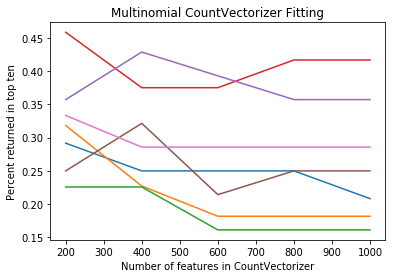

In [21]:
fig, ax = plt.subplots()
x = [200, 400, 600, 800, 1000]
for i in range(7):
    samples = test_events.sample(50)
    y = []
    for model in models:
        y.append(top_ten_rate(samples, model[1], model[0]))
    plt.plot(x,y)
plt.title('Multinomial CountVectorizer Fitting')
plt.xlabel('Number of features in CountVectorizer')
plt.ylabel('Percent returned in top ten')
plt.savefig('Multinomil.pdf')
plt.show()  